In [1]:
# Importing Important Libraries

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Reading CSV from dataset having 42k images.
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample=pd.read_csv("Downloads/sample_submission.csv")

In [3]:
print("Training Set Shape :",train.shape)
print("Test Set Shape :",test.shape)

Training Set Shape : (42000, 785)
Test Set Shape : (28000, 784)


In [4]:
#Creating X & Y from Dataset
Y=train['label']
Y=Y.values
X=train.drop(['label'],axis=1)
X=X.values
test=test.values

In [5]:
print("X's Shape : ",X.shape)
print("Y's Shape : ",Y.shape)
print("Test Dataset's Shape : ",test.shape)

X's Shape :  (42000, 784)
Y's Shape :  (42000,)
Test Dataset's Shape :  (28000, 784)


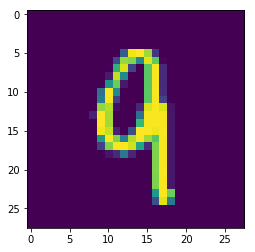

In [6]:
# Plotting an Example Image
t=X.reshape(-1,28,28)
plt.imshow(t[np.random.randint(0,41999)])
plt.show()

In [7]:
# Normalizing Dataset
X=X/255
test=test/255

In [8]:
# Doing One Hot Encoding On Labels
def ohe(C,vector):
    C=tf.constant(C,name="C")
    one_hot_matrix = tf.one_hot(vector,C,axis=1)
    with tf.Session() as sess:
        ohot = sess.run(one_hot_matrix)
    return ohot
Y=ohe(10,Y)

In [9]:
# Transposing Dataset To Make it in using
X=X.T
Y=Y.T
test=test.T
X_train=X[:,:40000]
Y_train=Y[:,:40000]
X_dev=X[:,40000:]
Y_dev=Y[:,40000:]

In [10]:
print("X-Train Shape:{0}\nY-Train Shape:{1}\nX-dev Shape:{2}\nY-dev Shape :{3}\nTest Set Shape :{4}".format(X_train.shape,Y_train.shape,X_dev.shape,Y_dev.shape,test.shape))

X-Train Shape:(784, 40000)
Y-Train Shape:(10, 40000)
X-dev Shape:(784, 2000)
Y-dev Shape :(10, 2000)
Test Set Shape :(784, 28000)


### Creating  A Tensorflow Architecture &nbsp;

In [11]:
### Create Placeholders for Data
def create_placeholder(n_x,n_y):
    X=tf.placeholder(tf.float32,name="X",shape=(n_x,None))
    Y=tf.placeholder(tf.float32,name="Y",shape=(n_y,None))
    return X,Y

In [12]:
#Initialize Parameter :    
def initParams(L,layer_size):  # L : No of Layers layer_size : Size of each Layer
    params={}
    for i in range(L):
        params['W'+str(i+1)]=tf.get_variable(name=("W"+str(i+1)),shape=[layer_size[i+1],layer_size[i]],initializer=tf.contrib.layers.xavier_initializer())
        params['b'+str(i+1)]= tf.get_variable(name=("b"+str(i+1)),shape=[layer_size[i+1],1],initializer=tf.zeros_initializer())
    
    return params

In [13]:
# Linear Propagation with RELU
def linear_prop(X,W,b):
    Z=tf.add(tf.matmul(W,X),b)
    A=tf.nn.relu(Z)
    return A

In [14]:
#Forward Propagation
def fwdprop(X,params,L):
    for i in range(1,L):
        X=linear_prop(X,params['W'+str(i)],params['b'+str(i)])
    Z=tf.add(tf.matmul(params['W'+str(i+1)],X),params['b'+str(i+1)])
    return Z

In [15]:
# Function to compute Cost
def compute_cost(A,Y):
    logits = tf.transpose(A)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=labels))
    return cost

In [16]:
# NN Model
def model(X_train,Y_train,X_test,Y_test,learning_rate = 0.01,num_epochs = 300, minibatch_size = 32, print_cost = True):
    L=4
    layer_size=[X_train.shape[0],300,100,25,Y_train.shape[0]]
    costs=[]
    X, Y = create_placeholder(X_train.shape[0],Y_train.shape[0])
    params=initParams(L,layer_size)
    A=fwdprop(X,params,L)
    cost = compute_cost(A,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    miniX=[]
    miniY=[]
    for i in range(1024,40000,1024):
        miniX.append(X_train[:,i-1024:i])
        miniY.append(Y_train[:,i-1024:i])
    miniX.append(X_train[:,i:40000])
    miniY.append(Y_train[:,i:40000])

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            for i in range(len(miniX)):
                _ , mb_cost = sess.run([optimizer, cost], feed_dict={X: miniX[i], Y: miniY[i]})
                epoch_cost+=mb_cost
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            
            
            
            if epoch%50==0:
                correct_prediction = tf.equal(tf.argmax(A), tf.argmax(Y))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            # Calculate accuracy on the test set
                print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
                print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        params = sess.run(params)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(A), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        

        return params





    

Cost after epoch 0: 28.754080
Train Accuracy: 0.935675
Test Accuracy: 0.9285
Train Accuracy: 0.99455
Test Accuracy: 0.969
Cost after epoch 100: 0.000476
Train Accuracy: 1.0
Test Accuracy: 0.9775
Train Accuracy: 1.0
Test Accuracy: 0.9775
Cost after epoch 200: 0.000004
Train Accuracy: 1.0
Test Accuracy: 0.977
Train Accuracy: 1.0
Test Accuracy: 0.977


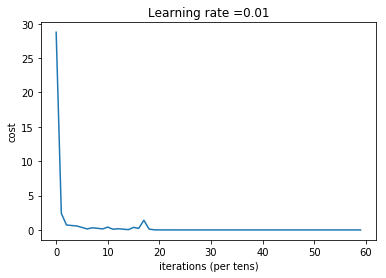

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9775


In [17]:
tf.reset_default_graph()
params=model(X_train,Y_train,X_dev,Y_dev)


In [18]:
def pred(test,params):
    X=tf.placeholder(tf.float32,name="X",shape=(test.shape[0],None))
    A=fwdprop(X,params,4)
    Y=tf.nn.softmax(A)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        predict=sess.run(Y,feed_dict={X:test})
    return predict
        

In [19]:
# Predicting On Test Set
predictions = pred(test,params)

In [20]:
#Converting result to Single Digit Array
result=np.argmax(predictions,axis=0)

In [21]:
t=test.T.reshape(-1,28,28)

1


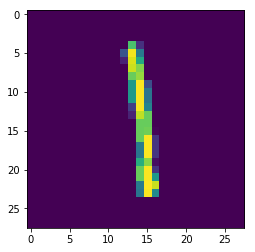

In [22]:
k=222  # Replace it with any no to check
plt.imshow(t[k])
print(result[k])
plt.show()

In [23]:
final=pd.DataFrame(result,columns=["Label"])
final['ImageId']=sample['ImageId']

In [24]:
final = final[['ImageId', 'Label']]


In [25]:
final.to_csv("submission.csv", index=False)